In [24]:
import os 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import checkpoints
import matplotlib.pyplot as plt
from tifffile import imread, imsave
import torch
import torch.utils.data as dt

In [25]:
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP-JAX')
# os.chdir(r'C:\Users\ankit\Desktop\Msc AIML\msc-project\GAP-JAX')
from gap_jax.BinomDataset_JAX import BinomDataset
from  gap_jax.GAP_JAX_Trainer import Trainer, TrainState
from gap_jax.GAP_UNET_ResBlock_JAX import UN

In [26]:
data = np.concatenate((imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/trainingDataGT.tif'), imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')))

: 

In [ ]:
print(data.shape)

(2048, 512, 512)


In [ ]:
def psnrToString(inp):
    if inp < 0:
        return 'm'+str(-inp)
    else:
        return str(inp)

minpsnr = -40
maxpsnr = -5

name = 'm40tom5-256x256-jax-base-v5'
# CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/'
# CHECKPOINT_PATH  = "C:\\Users\\ankit\\Desktop\\Msc AIML\\Data\\checkpoints\\models\\jax\\windows\\"
CHECKPOINT_PATH = '/home/ankith/temp/test/'
CHECKPOINT_PATH, name

('/home/ankith/temp/test/', 'm40tom5-256x256-jax-base-v5')

In [ ]:
maxepochs = 30 # train longer for better results

# Create pytorch dataset
dataset = BinomDataset(data = data[:round(data.shape[0]*0.9)], windowSize = 256, minPSNR = minpsnr, maxPSNR = maxpsnr)
val_dataset = BinomDataset(data = data[round(data.shape[0]*0.9):], windowSize = 256, minPSNR = minpsnr, maxPSNR = maxpsnr)

# Create pytorch dataloader for training and validation sets
train_loader = dt.DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True, pin_memory=False, num_workers=4, collate_fn= lambda batch: np.array(batch)) ## Changing the batch size from 32 to 16 to fit inside the gpu
val_loader = dt.DataLoader(val_dataset, batch_size=4, shuffle=False, drop_last=True,  pin_memory=False, num_workers=4, collate_fn= lambda batch: np.array(batch))

# img =  next(iter(val_loader))

# print(img.shape)

In [ ]:
model = UN(channels = 1, levels=10, depth=6, start_filts=28, up_mode = 'transpose')

In [ ]:
len(val_loader)

51

In [ ]:
maxepochs = 25 # train longer for better results

trainer = Trainer(root_dir= os.path.join(CHECKPOINT_PATH, name),
                  gradient_clip_val=0.5,
                  epochs= maxepochs,
                  dataloader= train_loader,
                  model = model)


Using Dummy data of shape : (1, 256, 256, 1)
GPU detected with 1 Device(s).


In [10]:
import warnings
warnings.filterwarnings("ignore", message="os.fork()")
warnings.filterwarnings("ignore", message="Unable to register cuDNN factory")
warnings.filterwarnings("ignore", message="Unable to register cuFFT factory")
warnings.filterwarnings("ignore", message="Unable to register cuBLAS factory")
warnings.filterwarnings("ignore", message="Difference at")

trainer.train_model(train_loader= train_loader,
                    val_loader= val_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: 0.0023083901032805443


Train Step Loss: 0.003225371241569519


Train Step Loss: 0.0012290795566514134


Train Step Loss: -0.001013380941003561


Train Step Loss: -0.004248729441314936


Train Step Loss: -0.00665274215862155


Train Step Loss: -0.012131364084780216


Train Step Loss: -0.009991023689508438


Train Step Loss: -0.03230348974466324


Train Step Loss: -0.013921852223575115


Train Step Loss: -0.043074093759059906


Train Step Loss: -0.022240446880459785


Train Step Loss: -0.05221519619226456


Train Step Loss: -0.08150669932365417


Train Step Loss: -0.12197566032409668


Train Step Loss: -0.06565594673156738


Train Step Loss: -0.06514263153076172


Train Step Loss: -0.03888256475329399


Train Step Loss: -0.10751964151859283


Train Step Loss: -0.09193532168865204


Train Step Loss: -0.11436720192432404


Train Step Loss: -0.051084503531455994


Train Step Loss: -0.13213218748569489


Train Step Loss: -0.19360212981700897


Train Step Loss: -0.076775506

/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Val Loss: -0.13441424071788788



/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.16873933374881744


Train Step Loss: -0.34235692024230957


Train Step Loss: -0.16450071334838867


Train Step Loss: -0.31004762649536133


Train Step Loss: -0.1411462128162384


Train Step Loss: -0.2504955530166626


Train Step Loss: -0.20084920525550842


Train Step Loss: -0.16915513575077057


Train Step Loss: -0.22032123804092407


Train Step Loss: -0.13252615928649902


Train Step Loss: -0.12488202005624771


Train Step Loss: -0.16628406941890717


Train Step Loss: -0.12947991490364075


Train Step Loss: -0.18484048545360565


Train Step Loss: -0.27258598804473877


Train Step Loss: -0.4248453676700592


Train Step Loss: -0.1285398155450821


Train Step Loss: -0.043395355343818665


Train Step Loss: -0.091528981924057


Train Step Loss: -0.0877017080783844


Train Step Loss: -0.07223616540431976


Train Step Loss: -0.21005870401859283


Train Step Loss: -0.12535038590431213


Train Step Loss: -0.1189914122223854


Train Step Loss: -0.37027913331985474


Train 

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.11677538603544235


Train Step Loss: -0.18099071085453033


Train Step Loss: -0.02287195809185505


Train Step Loss: -0.08444800972938538


Train Step Loss: -0.13053561747074127


Train Step Loss: -0.10720953345298767


Train Step Loss: -0.1302897036075592


Train Step Loss: -0.2006659060716629


Train Step Loss: -0.1771223545074463


Train Step Loss: -0.1685481071472168


Train Step Loss: -0.16819778084754944


Train Step Loss: -0.3149084746837616


Train Step Loss: -0.39070919156074524


Train Step Loss: -0.24529072642326355


Train Step Loss: -0.19765527546405792


Train Step Loss: -0.4126039743423462


Train Step Loss: -0.1753750890493393


Train Step Loss: -0.12490539252758026


Train Step Loss: -0.22620925307273865


Train Step Loss: -0.23076531291007996


Train Step Loss: -0.10764946043491364


Train Step Loss: -0.22589871287345886


Train Step Loss: -0.2266993522644043


Train Step Loss: -0.25415298342704773


Train Step Loss: -0.1208619475364685


Train St

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.30236655473709106


Train Step Loss: -0.3268786668777466


Train Step Loss: -0.12867701053619385


Train Step Loss: -0.23265966773033142


Train Step Loss: -0.2398419976234436


Train Step Loss: -0.14750438928604126


Train Step Loss: -0.08538709580898285


Train Step Loss: -0.10888132452964783


Train Step Loss: -0.3286477327346802


Train Step Loss: -0.2735541760921478


Train Step Loss: -0.01781228929758072


Train Step Loss: -0.2673117220401764


Train Step Loss: -0.16492541134357452


Train Step Loss: -0.13356560468673706


Train Step Loss: -0.2050972431898117


Train Step Loss: -0.14935702085494995


Train Step Loss: -0.2754114866256714


Train Step Loss: -0.2029855102300644


Train Step Loss: -0.1323893815279007


Train Step Loss: -0.21495118737220764


Train Step Loss: -0.161750927567482


Train Step Loss: -0.167680561542511


Train Step Loss: -0.16838717460632324


Train Step Loss: -0.13031145930290222


Train Step Loss: -0.17060361802577972


Train Step L

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.1746068000793457


Train Step Loss: -0.13403546810150146


Train Step Loss: -0.2792211174964905


Train Step Loss: -0.22507143020629883


Train Step Loss: -0.3069896101951599


Train Step Loss: -0.1398906111717224


Train Step Loss: -0.0923115611076355


Train Step Loss: -0.11304058134555817


Train Step Loss: -0.16133299469947815


Train Step Loss: -0.13287319242954254


Train Step Loss: -0.1125291958451271


Train Step Loss: -0.1027291789650917


Train Step Loss: -0.2445010095834732


Train Step Loss: -0.2942716181278229


Train Step Loss: -0.1430550068616867


Train Step Loss: -0.1404367834329605


Train Step Loss: -0.08602157235145569


Train Step Loss: -0.09853038191795349


Train Step Loss: -0.24382160604000092


Train Step Loss: -0.20034483075141907


Train Step Loss: -0.26896435022354126


Train Step Loss: -0.11353281140327454


Train Step Loss: -0.06184788793325424


Train Step Loss: -0.2378891259431839


Train Step Loss: -0.2379681020975113


Train Step L

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.1565054953098297


Train Step Loss: -0.0696338564157486


Train Step Loss: -0.1284787952899933


Train Step Loss: -0.1738881915807724


Train Step Loss: -0.21083086729049683


Train Step Loss: -0.1840156614780426


Train Step Loss: -0.16012966632843018


Train Step Loss: -0.24518753588199615


Train Step Loss: -0.1441396325826645


Train Step Loss: -0.15937009453773499


Train Step Loss: -0.18836407363414764


Train Step Loss: -0.1303839087486267


Train Step Loss: -0.08851377665996552


Train Step Loss: -0.2486458420753479


Train Step Loss: -0.1961425095796585


Train Step Loss: -0.19308391213417053


Train Step Loss: -0.30097246170043945


Train Step Loss: -0.3606806993484497


Train Step Loss: -0.04445558786392212


Train Step Loss: -0.2259623259305954


Train Step Loss: -0.11146944761276245


Train Step Loss: -0.05418743938207626


Train Step Loss: -0.18368127942085266


Train Step Loss: -0.3498997688293457


Train Step Loss: -0.2080264538526535


Train Step L

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.18014362454414368


Train Step Loss: -0.08207117766141891


Train Step Loss: -0.05763719230890274


Train Step Loss: -0.09852880984544754


Train Step Loss: -0.024177229031920433


Train Step Loss: -0.20212258398532867


Train Step Loss: -0.31108739972114563


Train Step Loss: -0.0591953843832016


Train Step Loss: -0.15821093320846558


Train Step Loss: -0.09452033787965775


Train Step Loss: -0.2077728509902954


Train Step Loss: -0.2597174048423767


Train Step Loss: -0.23137903213500977


Train Step Loss: -0.2062300443649292


Train Step Loss: -0.056377869099378586


Train Step Loss: -0.14797109365463257


Train Step Loss: -0.2216968983411789


Train Step Loss: -0.24882642924785614


Train Step Loss: -0.389426589012146


Train Step Loss: -0.2374795824289322


Train Step Loss: -0.17472341656684875


Train Step Loss: -0.1389995813369751


Train Step Loss: -0.17824305593967438


Train Step Loss: -0.13085515797138214


Train Step Loss: -0.30661073327064514


Train 

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.1696467101573944


Train Step Loss: -0.17686524987220764


Train Step Loss: -0.240930438041687


Train Step Loss: -0.14275574684143066


Train Step Loss: -0.2770913243293762


Train Step Loss: -0.1635078489780426


Train Step Loss: -0.2880527377128601


Train Step Loss: -0.3153250217437744


Train Step Loss: -0.06508786976337433


Train Step Loss: -0.15311966836452484


Train Step Loss: -0.14211708307266235


Train Step Loss: -0.10950139164924622


Train Step Loss: -0.25300973653793335


Train Step Loss: -0.2043541967868805


Train Step Loss: -0.03739538788795471


Train Step Loss: -0.22902335226535797


Train Step Loss: -0.28381872177124023


Train Step Loss: -0.15389008820056915


Train Step Loss: -0.13297808170318604


Train Step Loss: -0.08077749609947205


Train Step Loss: -0.12629938125610352


Train Step Loss: -0.24655720591545105


Train Step Loss: -0.12929613888263702


Train Step Loss: -0.23952805995941162


Train Step Loss: -0.025525826960802078


Train 

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.10930085927248001


Train Step Loss: -0.11482751369476318


Train Step Loss: -0.21452069282531738


Train Step Loss: -0.15518903732299805


Train Step Loss: -0.19328556954860687


Train Step Loss: -0.31879922747612


Train Step Loss: -0.12513534724712372


Train Step Loss: -0.18675550818443298


Train Step Loss: -0.1807439923286438


Train Step Loss: -0.11731720715761185


Train Step Loss: -0.14346230030059814


Train Step Loss: -0.24735012650489807


Train Step Loss: -0.22758829593658447


Train Step Loss: -0.3468402624130249


Train Step Loss: -0.38378793001174927


Train Step Loss: -0.051132410764694214


Train Step Loss: -0.187511146068573


Train Step Loss: -0.2557213604450226


Train Step Loss: -0.164561927318573


Train Step Loss: -0.07274562865495682


Train Step Loss: -0.09858500212430954


Train Step Loss: -0.30002519488334656


Train Step Loss: -0.22922223806381226


Train Step Loss: -0.08370461314916611


Train Step Loss: -0.08712685108184814


Train St

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.0839926153421402


Train Step Loss: -0.2804691791534424


Train Step Loss: -0.08993758261203766


Train Step Loss: -0.14321807026863098


Train Step Loss: -0.11795321106910706


Train Step Loss: -0.20158207416534424


Train Step Loss: -0.14966970682144165


Train Step Loss: -0.2831750214099884


Train Step Loss: -0.01771554723381996


Train Step Loss: -0.40420177578926086


Train Step Loss: -0.1687256097793579


Train Step Loss: -0.10175804048776627


Train Step Loss: -0.16940879821777344


Train Step Loss: -0.1847839206457138


Train Step Loss: -0.16710346937179565


Train Step Loss: -0.07278737425804138


Train Step Loss: -0.1687464714050293


Train Step Loss: -0.24796919524669647


Train Step Loss: -0.11584649980068207


Train Step Loss: -0.09940870106220245


Train Step Loss: -0.11304086446762085


Train Step Loss: -0.2168419510126114


Train Step Loss: -0.1026194766163826


Train Step Loss: -0.2709701657295227


Train Step Loss: -0.1113012284040451


Train Ste

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Step Loss: -0.15547919273376465


Train Step Loss: -0.3528042733669281


Train Step Loss: -0.018249642103910446


Train Step Loss: -0.357631653547287


Train Step Loss: -0.21781474351882935


Train Step Loss: -0.12180415540933609


Train Step Loss: -0.08233882486820221


Train Step Loss: -0.19194121658802032


Train Step Loss: -0.24576619267463684


Train Step Loss: -0.02937166951596737


Train Step Loss: -0.1251562237739563


Train Step Loss: -0.19131305813789368


Train Step Loss: -0.06984107196331024


Train Step Loss: -0.18179087340831757


Train Step Loss: -0.21520942449569702


Train Step Loss: -0.2577749490737915


Train Step Loss: -0.11905315518379211


Train Step Loss: -0.11835738271474838


Train Step Loss: -0.13951462507247925


Train Step Loss: -0.25368690490722656


Train Step Loss: -0.1765940934419632


Train Step Loss: -0.11977274715900421


Train Step Loss: -0.08063799887895584


Train Step Loss: -0.4540177583694458


Train Step Loss: -0.08734536170959473


Train

Training:   0%|          | 0/460 [00:00<?, ?it/s]

: 

In [9]:
state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, name),
                                                    target=trainer.state.params)


In [12]:
state = TrainState.create(apply_fn=trainer.state.apply_fn,
                                       params=state_dict,
                                       tx=trainer.state.tx)

In [13]:
state.params

{'params': {'down_convs_0': {'conv1': {'kernel': Array([[[[ 0.05515566,  0.00617756, -0.13073674, ..., -0.07872   ,
              -0.0226215 , -0.14953497],
             [-0.01273071,  0.08735669,  0.12386347, ...,  0.01430066,
               0.11021916,  0.03001465],
             [ 0.06250909, -0.03424459,  0.03527211, ...,  0.03263347,
              -0.13569732,  0.00188475],
             ...,
             [-0.01195555, -0.05462588, -0.12352853, ...,  0.03367089,
               0.0997187 , -0.02899   ],
             [-0.14639236,  0.03535993,  0.11657771, ...,  0.15635484,
               0.14617674, -0.10805395],
             [-0.11584629,  0.01133838,  0.028397  , ...,  0.0147537 ,
              -0.06618507, -0.12476844]],
    
            [[-0.04548115, -0.10871051, -0.14839475, ..., -0.13792333,
               0.07786202,  0.07458901],
             [-0.0059409 ,  0.09873955, -0.02237487, ...,  0.10175254,
               0.04149703,  0.14158411],
             [-0.10638068, -0.05325

In [14]:
trainer.load_model()

In [15]:
trainer.state.params

{'params': {'down_convs_0': {'conv1': {'kernel': Array([[[[ 0.05515566,  0.00617756, -0.13073674, ..., -0.07872   ,
              -0.0226215 , -0.14953497],
             [-0.01273071,  0.08735669,  0.12386347, ...,  0.01430066,
               0.11021916,  0.03001465],
             [ 0.06250909, -0.03424459,  0.03527211, ...,  0.03263347,
              -0.13569732,  0.00188475],
             ...,
             [-0.01195555, -0.05462588, -0.12352853, ...,  0.03367089,
               0.0997187 , -0.02899   ],
             [-0.14639236,  0.03535993,  0.11657771, ...,  0.15635484,
               0.14617674, -0.10805395],
             [-0.11584629,  0.01133838,  0.028397  , ...,  0.0147537 ,
              -0.06618507, -0.12476844]],
    
            [[-0.04548115, -0.10871051, -0.14839475, ..., -0.13792333,
               0.07786202,  0.07458901],
             [-0.0059409 ,  0.09873955, -0.02237487, ...,  0.10175254,
               0.04149703,  0.14158411],
             [-0.10638068, -0.05325

In [16]:
dataTest = imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT =imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')[:1]
dataTest.shape

(1, 512, 512)

inpT shape (512, 512, 1)
inp shape: (512, 512)
out shape: (512, 512, 1)
332 0 44.3373404001294 272.0 17.0


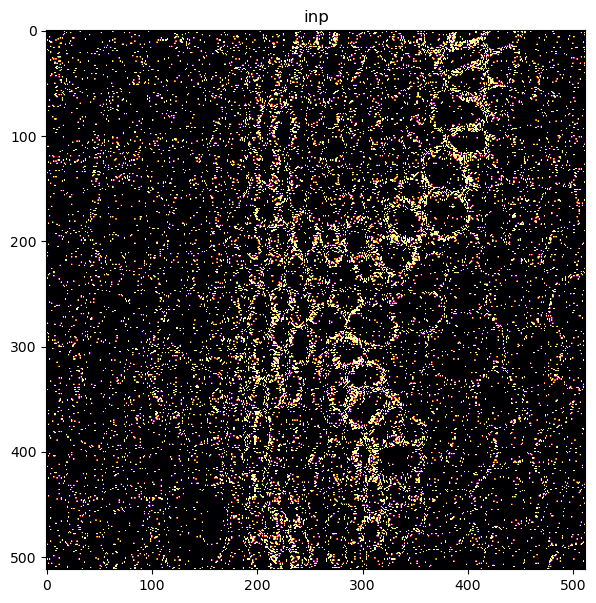

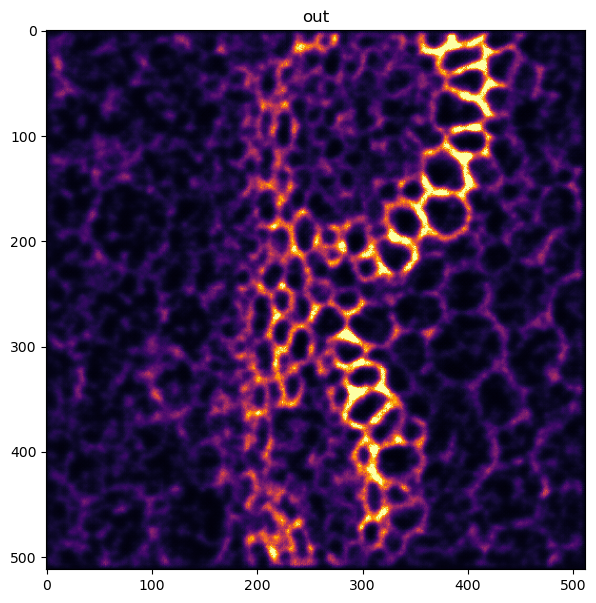

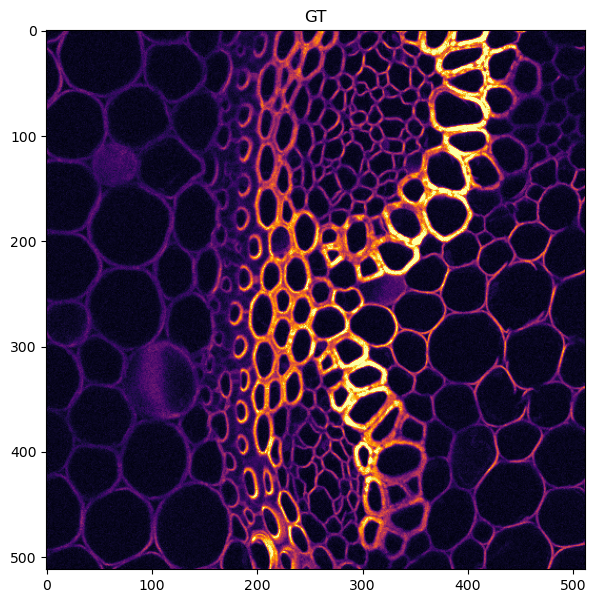

In [23]:
for inp, gt in zip(dataTest, dataTestGT):
    inpT = jnp.expand_dims(inp.astype(jnp.float32), axis = -1)
    print(f'inpT shape {inpT.shape}')
    
    out = jnp.exp(model.apply({'params': trainer.state.params['params']}, inpT))
    print(f'inp shape: {inp.shape}')
    print(f'out shape: {out.shape}')
    out = inp.sum() * out / out.sum()

    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    vmax = np.percentile(gt,99)

    plt.figure(figsize=(7,7))
    plt.imshow(inp,vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('inp')
    plt.show()
    
    # vmax = np.percentile(gt,99)
    plt.figure(figsize=(7,7))
    plt.imshow(out[0,:,:,0],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('out')
    plt.show()
    
    # vmax = np.percentile(gt,99)
    plt.figure(figsize=(7,7))
    plt.imshow(gt,vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('GT')
    plt.show()

   

In [16]:
out.min(), inp.min(), gt.min(), out.max(), inp.max(), gt.max()

(Array(-11.515526, dtype=float32),
 0.0,
 0.0,
 Array(22.228582, dtype=float32),
 56.50873032981246,
 9.088920968132209)

In [38]:
out.sum(), inp.sum(), (inp.sum() * out/out.sum()).sum()

(Array(262144., dtype=float32), 262144.0, Array(262144., dtype=float32))

In [13]:
from flax.training import checkpoints
# CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/del/'
CHECKPOINT_PATH = "/home/ankith/temp/test/"
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)
checkpoints.save_checkpoint(ckpt_dir=CHECKPOINT_PATH,
                                    target=trainer.state.params,
                                    step = 0,
                                    overwrite=True)

'/home/ankith/temp/test/checkpoint_0'

In [33]:
img = next(iter(train_loader))
img.shape

/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(4, 256, 256, 2)

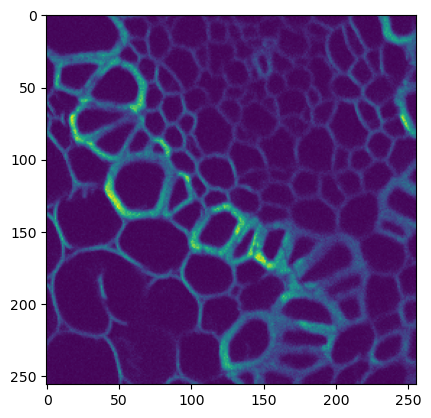

In [38]:
plt.imshow(img[1,:,:,0])

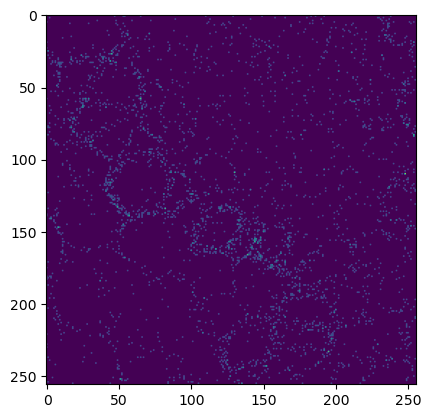

In [39]:
plt.imshow(img[1,:,:,1])

In [48]:
img = np.arange(4 * 32 * 32 * 2).reshape((4, 32, 32 ,2))

In [52]:
img[-1:, :,:,1:].shape

(1, 32, 32, 1)

In [11]:
1e6

1000000.0